# MATH50003 (2024–25)
# Lab 10: VI.3 Gaussian Quadrature

We complete the module where we started: computing integrals via quadrature.
We saw how interpolation leads to interpolatory quadrature rules, but we were
left with the question on how to choose the points. Orthogonal polynomials
provide the answer: The roots (zeros) of degree $n$ polynomials give interpolatory
quadrature rules with the special property that they are exact for polynomials of twice
the degree. Moreover, they lead to effective transforms from values of functions to
coefficients in an orthogonal polynomial expansion. In this lab we realise these
results numerically.

**Learning Outcomes**

Mathematical knowledge:

1. Roots of orthogonal polynomials and truncated Jacobi matrices.
2. Gaussian quadrature via eigenvalues of a truncated Jacobi matrix.
3. Transforms via Gaussian quadrature.

Coding knowledge:

1. `eigvals` and `eigen` for computing eigenvalues and eigenvectors

In [1]:
using Plots, LinearAlgebra

## VI.3.1 Roots of orthogonal polynomials and truncated Jacobi matrices

Gaussian quadrature is defined in terms of the roots of orthogonal polynomials.
We know how to compute orthogonal polynomials so in theory we could use Newton's method
(with dual numbers to compute the derivatives), however, we need _all_ roots and
it is a challenging problem choosing initial guesses.

Instead, we will recast the roots as eigenvalues of a symmetric tridiagonal matrix.
Having previously thought of eigenvalues as roots of a characteristic polynomial this
may appear to be a circular idea. But it turns out that there are very effective
algorithms for computing all eigenvalues (which are taught in Computational Linear Algebra),
and in fact finding roots of polynomials is typically done via eigenvalue algorithms.
For us we can use the `eigvals` function to compute these.

We can see this example with Chebyshev polynomials. We first construct a $10×10$ truncation of the Jacobi matrix
and compute its eigenvalues:

In [2]:
n = 10
J = SymTridiagonal(zeros(n), [1/sqrt(2); fill(1/2, n-2)])
x = eigvals(J)

10-element Vector{Float64}:
 -0.9876883405951374
 -0.8910065241883679
 -0.7071067811865475
 -0.4539904997395469
 -0.15643446504023067
  0.15643446504023079
  0.4539904997395465
  0.7071067811865471
  0.8910065241883682
  0.9876883405951377

By plotting we can see that we have successfully computed
the roots of $T_{10}(x)$:

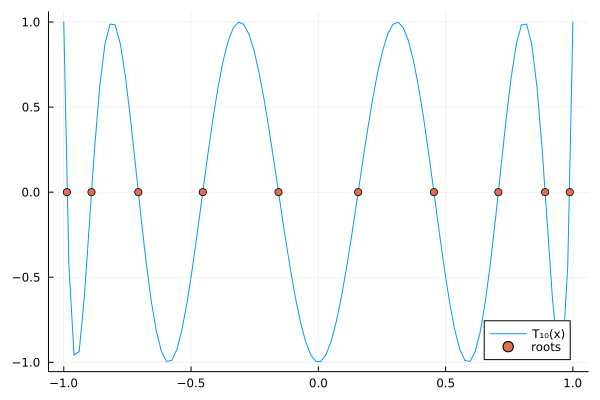

In [3]:
g = range(-1,1,100)
plot(g, cos.(n*acos.(g)); label="T₁₀(x)")
scatter!(x, zero(x); label="roots")

-----

**Problem 1(a)** Compute all 50 roots of the Chebyshev U polynomial $U_{50}(x)$.

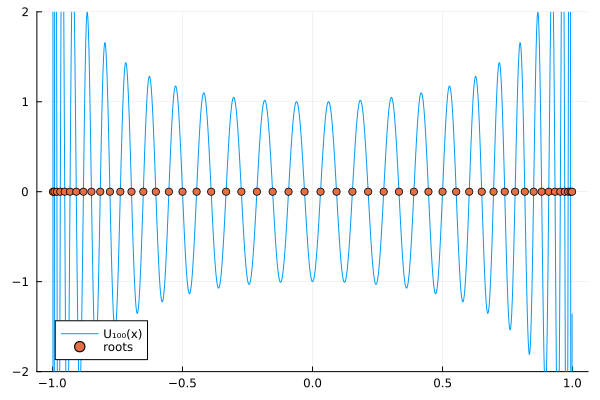

In [4]:
# TODO: Use a truncation Jacobi matrix to compute the roots of U₅₀(x)
# SOLUTION
# The Chebyshev U polynomials are already orthonormal with a simple Jacobi matrix:
g = range(-1,1,1000)
n = 50
J = SymTridiagonal(zeros(n), fill(1/2, n-1))
x = eigvals(J)

plot(g, sin.((n+1)*acos.(g)) ./ sin.(acos.(g)); label="U₁₀₀(x)", ylim=(-2,2))
scatter!(x, zero(x); label="roots")
# END

**Problem 1(b)** Compute all 100 roots of the Legendre polynomial $P_{100}(x)$
by constructing the multiplication matrix, symmetrising it and computing its eigenvalues.

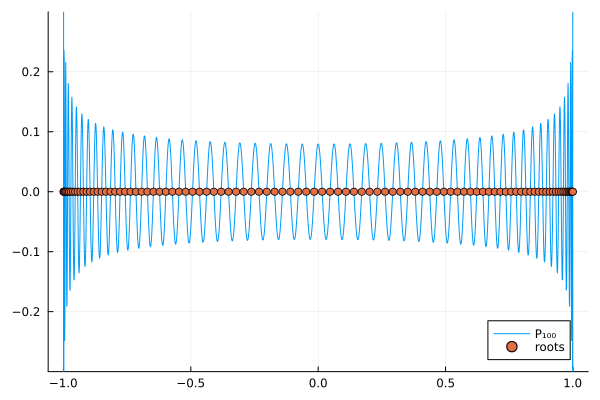

In [5]:
# TODO: Use a truncation Jacobi matrix to compute the roots of P₁₀₀(x).
# SOLUTION
# This is harder since the Jacobi matrix is not symmetric. But we can
# adapt the symmetrise code from last lecture to handle non-monic polynomials:
function symmetrise(X::Tridiagonal)
    n = size(X,1)
    k = zeros(n)
    k[1] = 1 # The normalisation for q_0(x) doesn't impact the Jacobi matrix
    for j = 1:n-1
        k[j+1] = k[j]*sqrt(X[j+1,j]/X[j,j+1])
    end
    SymTridiagonal(X.d,  X.dl .* k[1:n-1] ./ k[2:n])
end

n = 100
X = Tridiagonal((1:(n-1)) ./ (1:2:(2n-3)), zeros(n), (1:(n-1)) ./ (3:2:(2n-1)))
x = eigvals(symmetrise(X))

function legendrep(n, x)
    Pₖ₋₁ = 1.0
    if n == 0
        return Pₖ₋₁
    end
    Pₖ = x
    for k = 1:n-1
        Pₖ,Pₖ₋₁ = (2k+1)/(k+1) * x*Pₖ - k/(k+1)*Pₖ₋₁, Pₖ
    end
    Pₖ
end

g = range(-1,1,2000)
plot(g,legendrep.(n, g); ylims=(-0.3,0.3), label="P₁₀₀")
scatter!(x, zero(x); label="roots")

# END

------

## VI.3.2 Properties of Gaussian quadrature

Gaussian quadrature is a special quadrature rule that is exact for almost twice the degree of polynomials
as other interpolatory quadrature rules. It is defined in terms of the eigenvalues and eigenvectors
of the truncated Jacobi matrix as follows, using the Chebyshev T polynomials:

In [6]:
function gaussquadrature(J::SymTridiagonal)
    x,Q = eigen(J) # eigen computes the eigenvalues and eigenvectors.
    x, Q[1,:].^2
end


function gausschebyshevt(n)
    J = SymTridiagonal(zeros(n), [1/sqrt(2); fill(1/2, n-2)]) # symmetric Jacobi matrix
    x,w = gaussquadrature(J)
    x, π*w # ∫dx/sqrt(1-x^2)= π
end

x,w = gausschebyshevt(15)
@test w'exp.(x) ≈ 3.977463260506422 # = ∫exp(x)*dx/sqrt(1-x^2)

Test Passed

This approximation actually converges faster than exponentially!

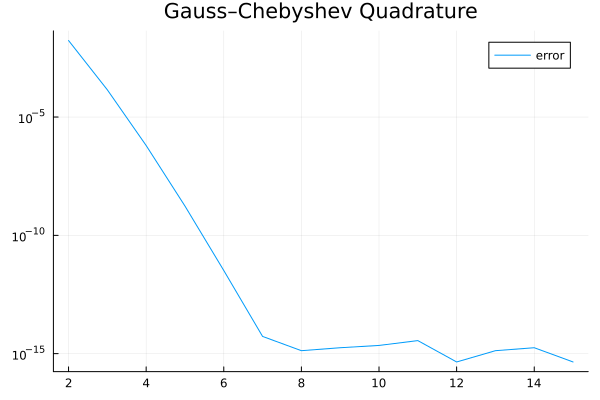

In [7]:
plot(2:15, [((x,w) = gausschebyshevt(n); abs(w'exp.(x) - 3.977463260506422)) for n=2:15]; yscale=:log10, label="error", title="Gauss–Chebyshev Quadrature")

Proving the convergence for general Gaussian quadrature requires complex analysis and potential theory results that are a bit too
advanced for Year 2. But in the specific case of Gauss–Chebyshev quadrature it can be proven via the connection with
the Cosine expansion.

We can also  use Gauss quadrature to compute expansion coefficients. To do this
we need to construct the orthonormal polynomials $q_0(x) = 1/\sqrt{π}$ and $q_n(x) = T_n(x)\sqrt{2/π}$:

In [8]:
function orthonormalchebyshevt(n, x) # normalized T_n(x),
    if n == 0
        1/sqrt(π)
    else
        cos(n*acos(x))*sqrt(2/π)
    end
end

orthonormalchebyshevt (generic function with 1 method)

The inverse transform from coefficients to values is the Vandermonde-like matrix:
$$
V_n = \begin{bmatrix}
q_0(x_1) & ⋯ & q_{n-1}(x_1) \\
⋮ & ⋱ & ⋱ \\
q_0(x_n) & ⋯ & q_{n-1}(x_n)
\end{bmatrix}
$$
The transform from values to coefficients of $q_n(x)$ is then $V_n^{-1}$, but we have a simple formula:
$$
V_n^{-1} = V_n^⊤{\rm diag}(w_1,…,w_n).
$$
We implement this as follows:

In [9]:
function chebyshevttransform(n)
    x,w = gausschebyshevt(n)
    V = orthonormalchebyshevt.((0:n-1)', x) # Vandermonde-like matrix for normalized T_n(x)
    V'*Diagonal(w) # transform matrix
end

n = 15
Q = chebyshevttransform(n)
c = Q*exp.(x) # expansion coefficients
@test c'*orthonormalchebyshevt.((0:n-1), 0.1) ≈ exp(0.1)

Test Passed

We can see that the above actually interpolates, using a more
oscillatory example where it's visually distinctive:

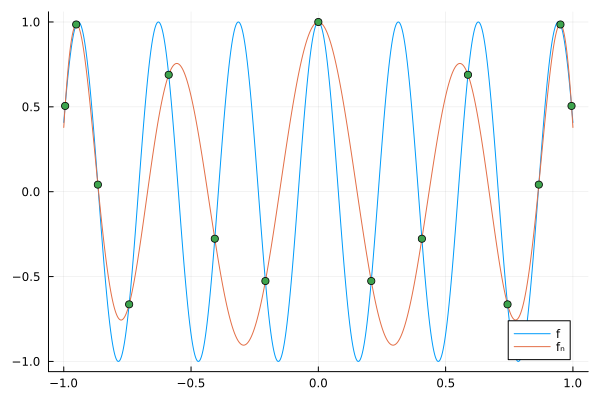

In [10]:
f = x -> cos(20x)
c = Q*f.(x) # expansion coefficients
g = range(-1,1,1000)
plot(g, f.(g); label="f")
plot!(g, orthonormalchebyshevt.((0:n-1)', g)*c; label="fₙ")
scatter!(x, f.(x); label=nothing)

Taking a few more points and the approximation will have converged to high accuracy,
actually super-exponentially fast.

---
**Problem 2** Compute the Gauss–Chebyshev U quadrature rule for $w(x) = \sqrt{1-x^2}$ on $[-1,1]$.

In [11]:
function gausschebyshevu(n)
    # TODO: implement Gauss–Chebyshev U quadrature
    # SOLUTION
    J = SymTridiagonal(zeros(n), fill(1/2, n-1)) # symmetric Jacobi matrix
    x,w = gaussquadrature(J)
    x, π*w/2 # ∫sqrt(1-x^2)dx= π/2
    # END
end

x,w = gausschebyshevu(3)
@test x ≈ [-1/sqrt(2),0,1/sqrt(2)]
@test w ≈ [0.3926990816987255, 0.7853981633974466, 0.3926990816987243]

Test Passed

**Problem 3(a)** Compute the Gauss–Legendre quadrature rule, for $w(x) = 1$ on $[-1,1]$.

In [12]:
function gausslegendre(n)
    # TODO: Compute the Gauss–Legendre quadrature rule for a uniform weight.
    # SOLUTION
    # We reuse the functions abobve
    X = Tridiagonal((1:(n-1)) ./ (1:2:(2n-3)), zeros(n), (1:(n-1)) ./ (3:2:(2n-1)))
    x,w = gaussquadrature(symmetrise(X))
    x,2w
    # END
end
x,w = gausslegendre(3)
@test x ≈ [-sqrt(3/5), 0, sqrt(3/5)]
@test w ≈ [5/9,8/9,5/9]

n = 5
x,w = gausslegendre(n)
@test w'exp.(x) ≈ exp(1)-exp(-1) # even just 5 points converges

# We saw in Theorem 20 that it is exact for about twice the degree
# of polynomial. We can test this numerically:

for k = 0:2n-1
    if iseven(k)
        @test w'x.^k ≈ 2/(k+1)
    else
        @test abs(w'x.^k) ≤ 1E-14
    end
end

**Problem 3(b)** Implement the following function that computes `orthonormallegendrep(n,x)` corresponding
to the orthonormalised Legendre polynomials.

In [13]:
function orthonormallegendrep(n, x)
    # TODO: implement the orthonormalised Legendre polynomials
    # SOLUTION
    # We will adapt symmetrise to get out the normalisation constants.
    # We don't need to keep track of all the normalisation constants this time.
    # A better implementation would work out the explicit formula for X[j+1,j]/X[j,j+1]
    # and avoid the memory allocation associated with making X.
    X = Tridiagonal((1:(n)) ./ (1:2:(2n-1)), zeros(n+1), (1:n) ./ (3:2:(2n+1)))
    k = 1/sqrt(2) # The normalisation for q_0(x)
    for j = 1:n
        k = k*sqrt(X[j+1,j]/X[j,j+1])
    end
    k*legendrep(n,x)
    # END
end

@test orthonormallegendrep(5, 0.1) ≈ 0.41939059365476206

Test Passed

**Problem 3(c)** Implement the Legendre transform from values of a function on Gauss–Legendre points to coefficients in
a Legendre expansion.

In [14]:
function legendreptransform(n)
    # TODO: Construct the n × n matrix mapping from samples at zeros of Legendre polynonials to coefficients
    # SOLUTION
    # Literally the exact same thing as chebyshevttransform
    x,w = gausslegendre(n)
    V = orthonormallegendrep.((0:n-1)', x) # Vandermonde-like matrix for normalized T_n(x)
    V'*Diagonal(w) # transform matrix
    # END
end

n = 15
x,w = gausslegendre(n)
Q = legendreptransform(n)
c = Q*exp.(x) # expansion coefficients
@test c'*orthonormallegendrep.((0:n-1), 0.1) ≈ exp(0.1)

Test Passed

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*